In [1]:
# load all packages we need
import os

import geopandas as gpd
import matplotlib.cm as cm  # 使用旧方式获取cmap
import matplotlib.colors as mcolors  # 使用Normalize需要从matplotlib.colors导入
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar
from scipy.stats import gaussian_kde
from shapely.geometry import Polygon
from shapely.ops import unary_union

In [2]:
# Define the scale bar function
def add_scale_bar(
    ax,
    scale_bar_start=0.05,
    scale_bar_length=0.2,
    scale_bar_y=0.02,
    scale_bar_thickness=600,
    scale_unit="km",
    labels_interval=5,
    zorder=10,
):
    """
    Add a custom scale bar to a matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axis to which the scale bar will be added.
        scale_bar_start (float): Starting position of the scale bar on the x-axis (fraction of total width).
        scale_bar_length (float): Total length of the scale bar (fraction of total width).
        scale_bar_y (float): Position of the scale bar on the y-axis (fraction of total height).
        scale_bar_thickness (int): Thickness of the scale bar in data coordinates (e.g., meters).
        scale_unit (str): Unit of the scale (e.g., 'km').
        labels_interval (int): Interval for scale labels in the given unit.
        zorder (int): Drawing order of the scale bar.
    """

    x_start, x_end = ax.get_xlim()
    y_start, y_end = ax.get_ylim()

    bar_x_start = x_start + scale_bar_start * (x_end - x_start)
    bar_x_end = bar_x_start + scale_bar_length * (x_end - x_start)
    bar_y = y_start + scale_bar_y * (y_end - y_start)

    num_sections = int(
        1 / (scale_bar_length / labels_interval)
    )  # Number of alternating sections
    bar_width = (bar_x_end - bar_x_start) / num_sections
    colors = ["black", "white"] * (num_sections // 2 + 1)

    for i in range(num_sections):
        rect = Rectangle(
            (bar_x_start + i * bar_width, bar_y),
            bar_width,
            scale_bar_thickness,
            color=colors[i],
            transform=ax.transData,
            clip_on=False,
            zorder=zorder,
        )
        ax.add_patch(rect)

    for i in range(num_sections + 1):
        ax.text(
            bar_x_start + i * bar_width,
            bar_y + scale_bar_thickness * 1.5,
            f"{i * labels_interval}",
            fontsize=10,
            color="black",
            ha="center",
            transform=ax.transData,
            zorder=zorder,
        )

    scale_bar_border = Rectangle(
        (bar_x_start, bar_y),
        bar_x_end - bar_x_start,
        scale_bar_thickness,
        linewidth=0.7,
        edgecolor="black",
        facecolor="none",
        transform=ax.transData,
        clip_on=False,
        zorder=zorder,
    )

    ax.add_patch(scale_bar_border)

    ax.text(
        bar_x_start + num_sections * bar_width + 0.3 * bar_width,
        bar_y + scale_bar_thickness * 1.5,
        scale_unit,
        fontsize=8,
        color="black",
        ha="left",
        transform=ax.transData,
        zorder=zorder,
    )

In [3]:
# Read in cleaned Inside Airbnb data
# (Please see the code for cleaning data:https://github.com/ukilay/PANA-FSDS-GROUP/blob/main/Cleaned%20Data/Data%20Cleaning%20Dec24.ipynb)
csv_urls = {
    2016: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2016_data.csv",
    2019: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2019_data.csv",
    2020: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2020_data.csv",
    2021: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2021_data.csv",
    2022: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2022_data.csv",
    2023: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2023_data.csv",
    2024: "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/Cleaned%20Data/cleaned_2024_data.csv",
}

data_2016 = pd.read_csv(csv_urls[2016])
data_2019 = pd.read_csv(csv_urls[2019])
data_2020 = pd.read_csv(csv_urls[2020])
data_2021 = pd.read_csv(csv_urls[2021])
data_2022 = pd.read_csv(csv_urls[2022])
data_2023 = pd.read_csv(csv_urls[2023])
data_2024 = pd.read_csv(csv_urls[2024])


# Read in shapefile of London's Borough
shapefile_url = "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/data/London_Borough/London_Borough_Excluding_MHW.shp"

boroughs = gpd.read_file(shapefile_url)
boroughs = boroughs.to_crs(epsg=27700)  # Ensure its projection to EPSG:27700

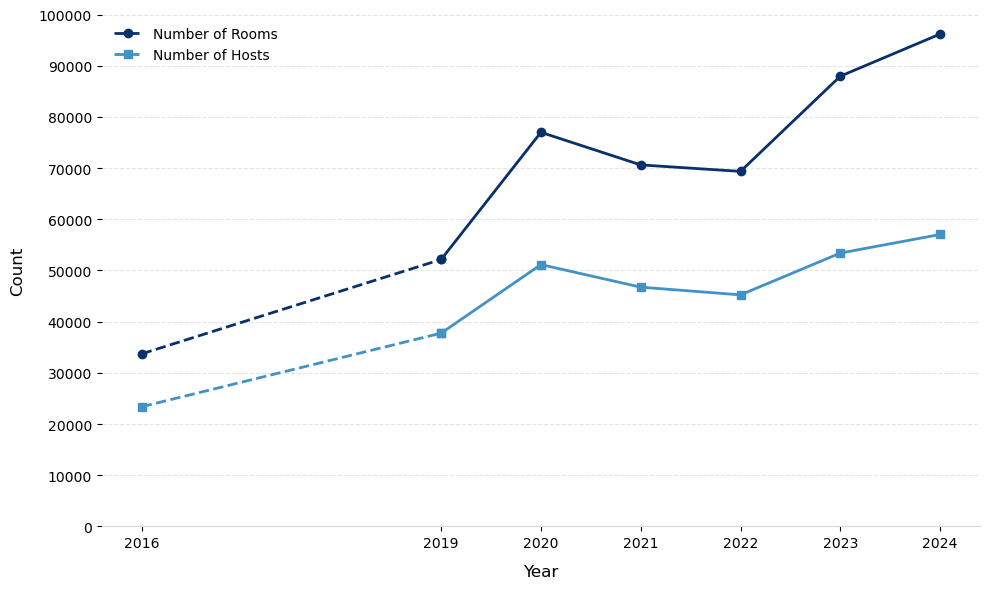

In [4]:
data_2016["year"] = 2016
data_2019["year"] = 2019
data_2020["year"] = 2020
data_2021["year"] = 2021
data_2022["year"] = 2022
data_2023["year"] = 2023
data_2024["year"] = 2024

# Combine all data
all_data = pd.concat(
    [data_2016, data_2019, data_2020, data_2021, data_2022, data_2023, data_2024]
)

# Calculate the total number of listings and unique hosts for each year
room_count = all_data.groupby("year")["id"].count()
host_count = all_data.groupby("year")["host_id"].nunique()

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot rooms and hosts with segmented line styles
plt.plot(
    room_count.index[:2],
    room_count.values[:2],
    marker="o",
    label="Number of Rooms",
    color="#08306B",
    linewidth=2,
    linestyle="--",
)  # Dashed for 2016-2019
plt.plot(
    room_count.index[1:],
    room_count.values[1:],
    marker="o",
    color="#08306B",
    linewidth=2,
)  # Solid for 2019-2024

plt.plot(
    host_count.index[:2],
    host_count.values[:2],
    marker="s",
    label="Number of Hosts",
    color="#4292C6",
    linewidth=2,
    linestyle="--",
)  # Dashed for 2016-2019
plt.plot(
    host_count.index[1:],
    host_count.values[1:],
    marker="s",
    color="#4292C6",
    linewidth=2,
)  # Solid for 2019-2024

# Add title, grid, and labels
plt.xlabel("Year", fontsize=12, labelpad=10)
plt.ylabel("Count", fontsize=12, labelpad=10)

# Set Y-axis limit to 100,000
plt.ylim(0, 100000)

# Set Y-axis ticks with 10000 intervals
plt.yticks(range(0, 100001, 10000))

# Customize the axes and gridlines
plt.grid(
    axis="y", color="#D9D9D9", linestyle="--", linewidth=0.8, alpha=0.7
)  # Show horizontal gridlines only
plt.gca().spines["top"].set_visible(False)  # Remove the top border
plt.gca().spines["right"].set_visible(False)  # Remove the right border
plt.gca().spines["left"].set_visible(False)  # Remove the left border
plt.gca().spines["bottom"].set_color("#D9D9D9")  # Set bottom border to light gray

# Adjust tick styles
plt.xticks(room_count.index, fontsize=10)
plt.yticks(fontsize=10)

# Set legend
plt.legend(
    fontsize=10, loc="upper left", frameon=False
)  # Single legend for simplified understanding

# Display the plot
plt.tight_layout()
plt.show()

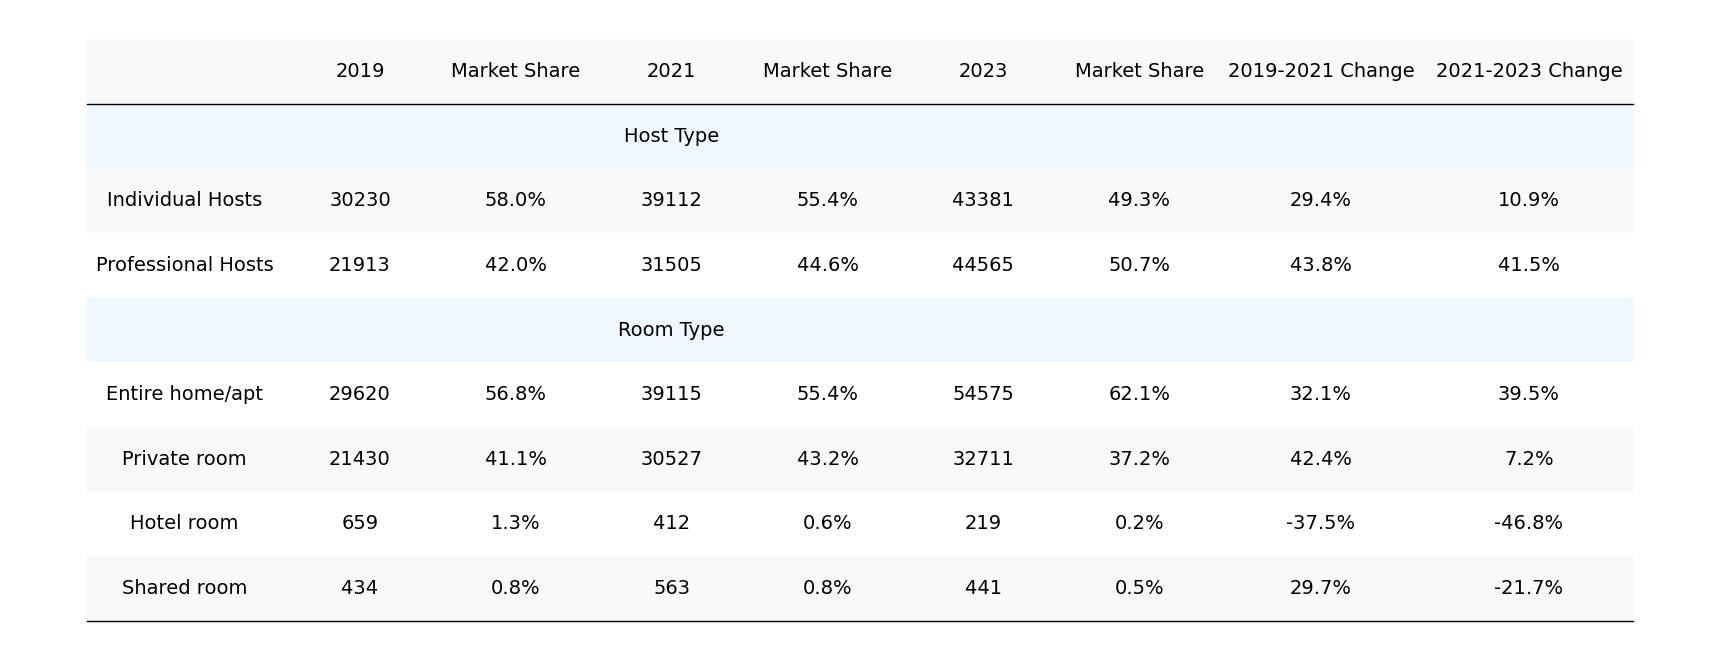

In [5]:
# Combine all data
data_combined = pd.concat([data_2019, data_2021, data_2023])

# Step 1: Add 'host_type' column to classify hosts
unique_hosts = (
    data_combined.groupby(["year", "host_id"])["calculated_host_listings_count"]
    .max()
    .reset_index()
)
unique_hosts["host_type"] = unique_hosts["calculated_host_listings_count"].apply(
    lambda x: "Individual Host" if x == 1 else "Professional Host"
)


# Step 2: Calculate Host Type Market Share
def calculate_host_market_share(data, unique_hosts):
    data = data.merge(unique_hosts, on=["year", "host_id"], how="left")
    total_listings = data.shape[0]  # Total number of listings
    host_type_counts = data.groupby("host_type").size()  # Total listings by host type
    market_share = (
        host_type_counts / total_listings
    ) * 100  # Market share by host type
    return host_type_counts, market_share


host_market_2019_counts, host_market_2019_share = calculate_host_market_share(
    data_2019, unique_hosts[unique_hosts["year"] == 2019]
)
host_market_2021_counts, host_market_2021_share = calculate_host_market_share(
    data_2021, unique_hosts[unique_hosts["year"] == 2021]
)
host_market_2023_counts, host_market_2023_share = calculate_host_market_share(
    data_2023, unique_hosts[unique_hosts["year"] == 2023]
)


# Step 3: Calculate Room Type Market Share
def calculate_room_market_share(data):
    total_listings = data.shape[0]  # Total number of listings
    room_counts = data["room_type"].value_counts()  # Total listings by room type
    market_share = (room_counts / total_listings) * 100  # Market share by room type
    return room_counts, market_share


room_counts_2019, room_market_2019 = calculate_room_market_share(data_2019)
room_counts_2021, room_market_2021 = calculate_room_market_share(data_2021)
room_counts_2023, room_market_2023 = calculate_room_market_share(data_2023)

# Step 4: Build DataFrame for Host Type
host_type_df = pd.DataFrame(
    {
        "Type": ["Individual Hosts", "Professional Hosts"],
        "2019": host_market_2019_counts.values,
        "2019 Market Share": [f"{x:.1f}%" for x in host_market_2019_share.values],
        "2021": host_market_2021_counts.reindex(
            host_market_2019_counts.index, fill_value=0
        ).values,
        "2021 Market Share": [
            f"{x:.1f}%"
            for x in host_market_2021_share.reindex(
                host_market_2019_counts.index, fill_value=0
            ).values
        ],
        "2023": host_market_2023_counts.reindex(
            host_market_2019_counts.index, fill_value=0
        ).values,
        "2023 Market Share": [
            f"{x:.1f}%"
            for x in host_market_2023_share.reindex(
                host_market_2019_counts.index, fill_value=0
            ).values
        ],
    }
)

# Step 5: Build DataFrame for Room Type
room_type_df = pd.DataFrame(
    {
        "Type": room_counts_2019.index.tolist(),
        "2019": room_counts_2019.values,
        "2019 Market Share": [f"{x:.1f}%" for x in room_market_2019.values],
        "2021": room_counts_2021.reindex(room_counts_2019.index, fill_value=0).values,
        "2021 Market Share": [
            f"{x:.1f}%"
            for x in room_market_2021.reindex(
                room_counts_2019.index, fill_value=0
            ).values
        ],
        "2023": room_counts_2023.reindex(room_counts_2019.index, fill_value=0).values,
        "2023 Market Share": [
            f"{x:.1f}%"
            for x in room_market_2023.reindex(
                room_counts_2019.index, fill_value=0
            ).values
        ],
    }
)

# Step 6: Combine DataFrames
final_table = pd.concat([host_type_df, room_type_df], ignore_index=True)


# Step 7: Calculate Percentage Changes
def calculate_change(row, year1, year2):
    if row[year1] > 0:
        return f"{((row[year2] - row[year1]) / row[year1]) * 100:.1f}%"
    return "-"


final_table["2019-2021 Change"] = final_table.apply(
    lambda row: calculate_change(row, "2019", "2021"), axis=1
)
final_table["2021-2023 Change"] = final_table.apply(
    lambda row: calculate_change(row, "2021", "2023"), axis=1
)

# Step 8: Reorder Columns
final_table = final_table[
    [
        "Type",
        "2019",
        "2019 Market Share",
        "2021",
        "2021 Market Share",
        "2023",
        "2023 Market Share",
        "2019-2021 Change",
        "2021-2023 Change",
    ]
]

# Step 9: Visualization
host_data = final_table.iloc[:2].values.tolist()  # Host type data
room_data = final_table.iloc[2:].values.tolist()  # Room type data

table_data = (
    [
        [
            "",
            "2019",
            "Market Share",
            "2021",
            "Market Share",
            "2023",
            "Market Share",
            "2019-2021 Change",
            "2021-2023 Change",
        ],  # Column headers
        ["", "", "", "Host Type", "", "", "", "", ""],
    ]
    + host_data
    + [["", "", "", "Room Type", "", "", "", "", ""]]
    + room_data
)

fig, ax = plt.subplots(figsize=(17, 8))
ax.axis("off")

cell_height = 1 / len(table_data)
col_widths = [0.15, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.16, 0.16]
cumulative_widths = [sum(col_widths[:i]) for i in range(len(col_widths) + 1)]

cell_fontsize = 14

for i, row in enumerate(table_data):
    for j, cell in enumerate(row):
        x = cumulative_widths[j]
        y = 1 - (i + 1) * cell_height
        color = "#f0f8ff" if i in [1, 4] else "#f9f9f9" if i % 2 == 0 else "white"
        ax.add_patch(
            Rectangle(
                (x, y), col_widths[j], cell_height, facecolor=color, edgecolor="none"
            )
        )
        ax.text(
            x + col_widths[j] / 2,
            y + cell_height / 2,
            str(cell),
            ha="center",
            va="center",
            fontsize=cell_fontsize,  # 单元格字体大小
        )

# Draw horizontal lines spanning all columns (1-9)
ax.plot(
    [0, cumulative_widths[-1]],
    [1 - cell_height, 1 - cell_height],
    color="black",
    linewidth=1,
)  # Header line
ax.plot([0, cumulative_widths[-1]], [0, 0], color="black", linewidth=1)  # Bottom border

plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.1)
plt.show()

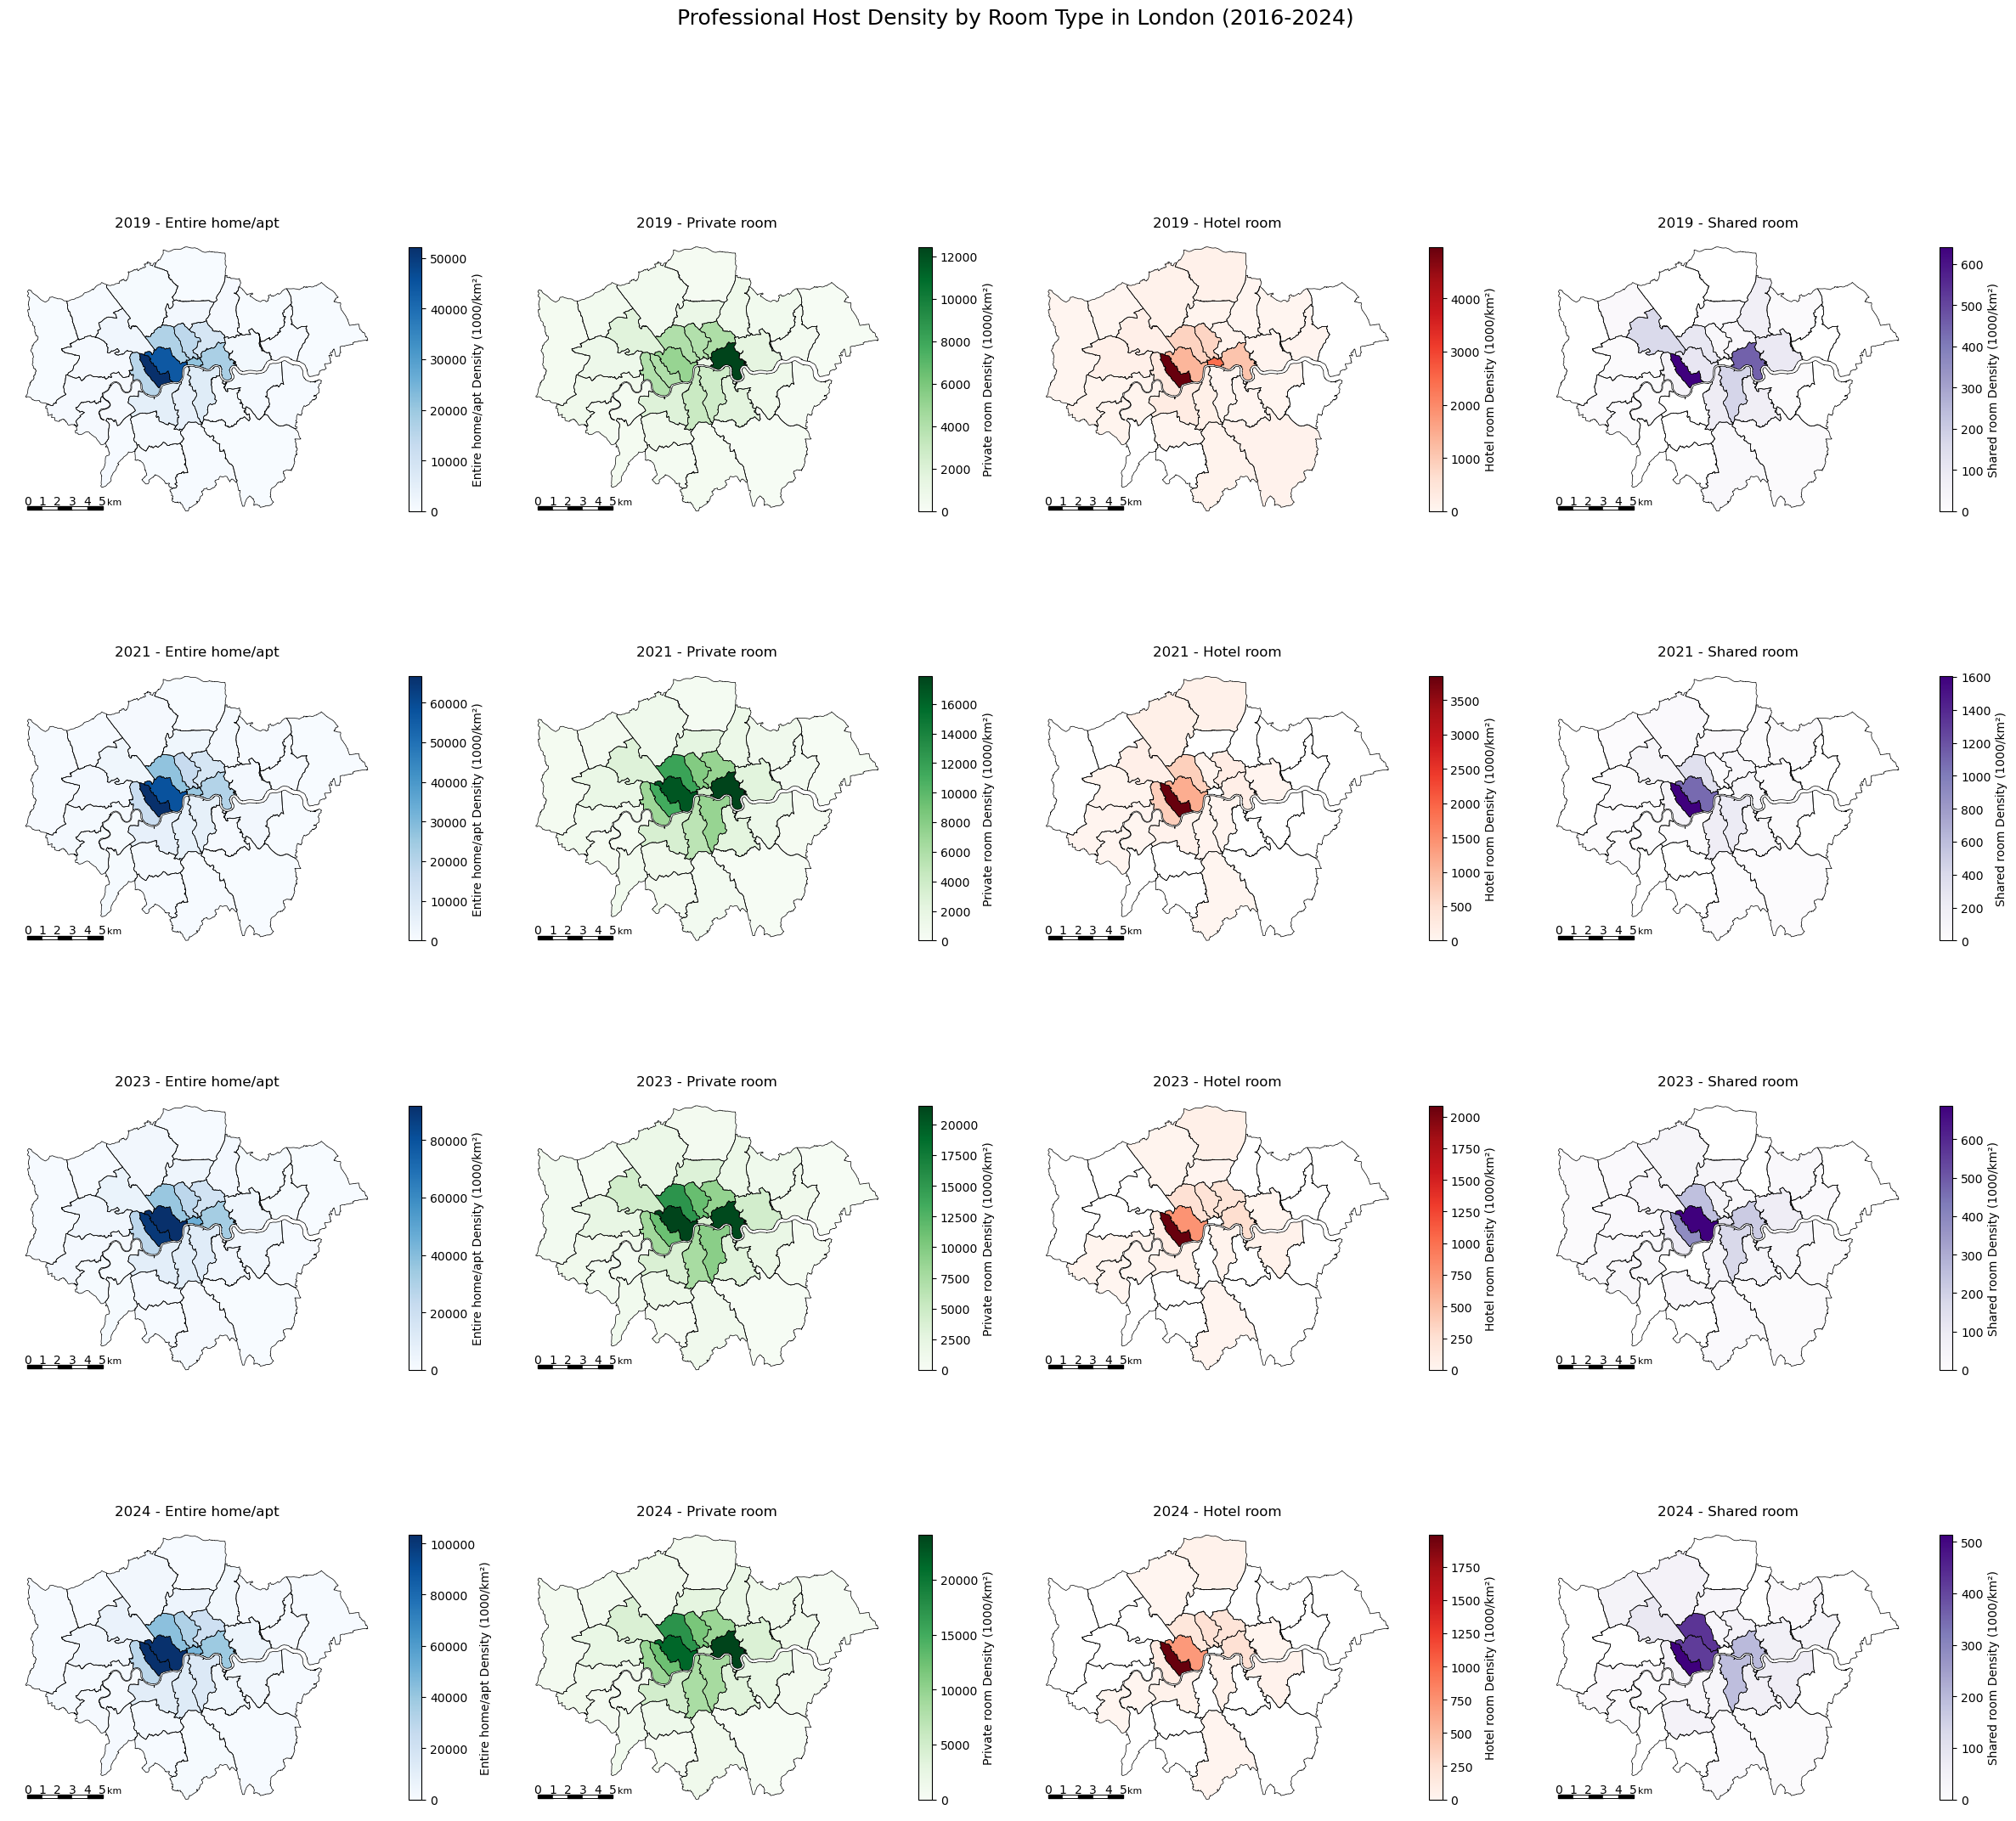

In [6]:
boroughs["area_km2"] = (
    boroughs["geometry"].to_crs(epsg=3395).area / 1e6
)  # 计算每个 Borough 的面积

# 数据处理
columns_needed = [
    "year",
    "host_id",
    "calculated_host_listings_count",
    "neighbourhood_cleansed",
    "room_type",
]
host_data = all_data[columns_needed].dropna()

# 添加 Host 类型
host_data["host_type"] = host_data["calculated_host_listings_count"].apply(
    lambda x: "Non-professional" if x <= 2 else "Professional"
)

# 计算密度
host_counts = (
    host_data.groupby(["year", "neighbourhood_cleansed", "room_type", "host_type"])
    .size()
    .reset_index(name="count")
)
host_counts = host_counts.merge(
    boroughs[["NAME", "area_km2"]],
    left_on="neighbourhood_cleansed",
    right_on="NAME",
    how="left",
)
host_counts["density"] = (host_counts["count"] / host_counts["area_km2"]) * 1000

# 转换为 GeoDataFrame
boroughs = boroughs.rename(columns={"NAME": "borough"})
data_geo = pd.merge(
    boroughs,
    host_counts,
    how="left",
    left_on="borough",
    right_on="neighbourhood_cleansed",
)

# 获取唯一房源类型和年份
room_types = host_data["room_type"].unique()
years = host_data["year"].unique()


# 绘图
def plot_combined_professional_density(
    data_geo, years, room_types, title, output_file, boroughs
):
    fig, axes = plt.subplots(
        len(years), len(room_types), figsize=(len(room_types) * 6, len(years) * 6)
    )
    colormaps = ["Blues", "Greens", "Reds", "Purples"]

    for row, year in enumerate(years):
        year_data = data_geo[data_geo["year"] == year]
        professional_data = year_data[year_data["host_type"] == "Professional"]

        for col, room_type in enumerate(room_types):
            cmap = colormaps[col % len(colormaps)]

            # 绘制 Professional Hosts
            ax = axes[row, col]
            subset = professional_data[professional_data["room_type"] == room_type]
            boroughs.boundary.plot(ax=ax, color="black", linewidth=0.5)
            subset.plot(
                column="density",
                cmap=cmap,
                legend=True,
                legend_kwds={"label": f"{room_type} Density (1000/km²)", "shrink": 0.5},
                ax=ax,
                vmin=0,
                vmax=subset["density"].max(),
                missing_kwds={"color": "lightgrey", "label": "No data"},
            )
            ax.set_title(f"{year} - {room_type}", fontsize=12)
            ax.axis("off")
            add_scale_bar(
                ax,
                scale_bar_start=0.05,
                scale_bar_length=0.2,
                scale_bar_y=0.05,
                scale_bar_thickness=600,
                scale_unit="km",
                labels_interval=1,
            )

    # 设置整体标题
    plt.suptitle(title, fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.savefig(output_file, dpi=300)
    plt.show()


# 绘制专业 Host 的密度分布图
plot_combined_professional_density(
    data_geo,
    years,
    room_types,
    "Professional Host Density by Room Type in London (2016-2024)",
    "combined_professional_host_density.png",
    boroughs,
)

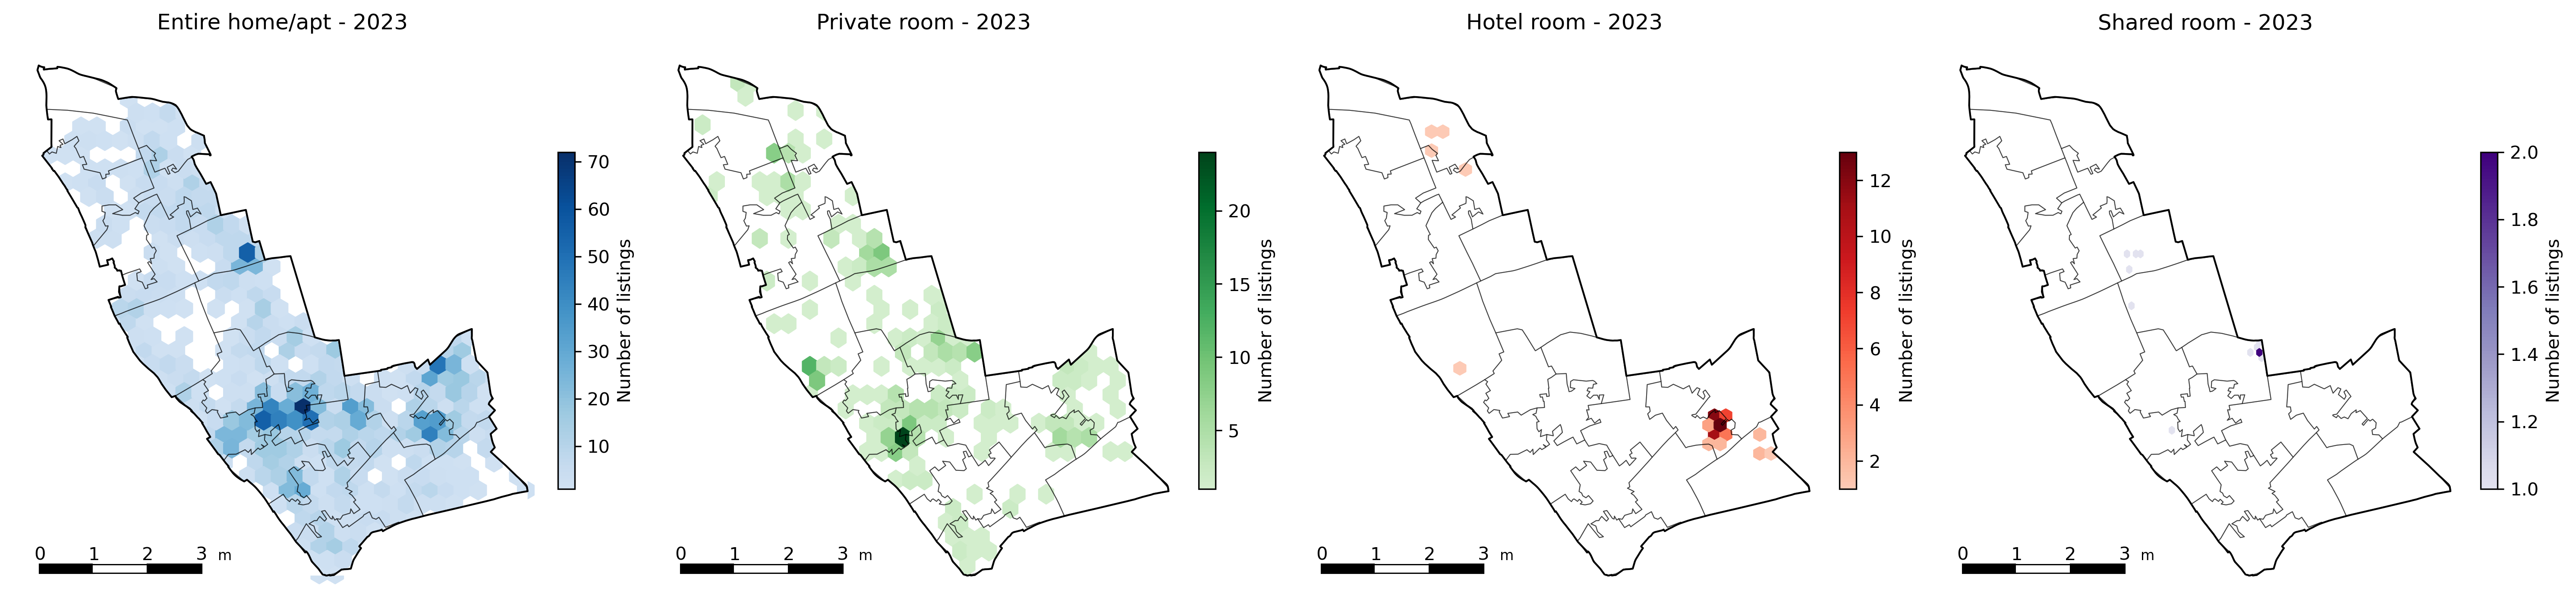

In [7]:
# 筛选 Kensington and Chelsea 子区域
KC_borough = boroughs[boroughs["borough"] == "Kensington and Chelsea"]
if KC_borough.empty:
    raise ValueError(
        "Kensington and Chelsea not found. Check the 'NAME' field in boroughs."
    )


# 读取 MSOA shapefile
msoa_url = "https://github.com/ukilay/PANA-FSDS-GROUP/raw/main/data/MSOA/MSOA_2011_London_gen_MHW.shp"
msoa = gpd.read_file(msoa_url)
msoa = msoa.to_crs(epsg=27700)

# 添加 Host 类型
data_2023["host_type"] = data_2023["calculated_host_listings_count"].apply(
    lambda x: "Non-professional" if x <= 2 else "Professional"
)

# 筛选 Professional Hosts 和 Kensington and Chelsea 的数据
data_2023_KC = data_2023[
    (data_2023["host_type"] == "Professional")
    & (data_2023["neighbourhood_cleansed"] == "Kensington and Chelsea")
]


# 定义 truncate_colormap 函数
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=100):
    """截取 colormap 的一部分以避免从白色开始"""
    new_cmap = ListedColormap(cmap(np.linspace(minval, maxval, n)))
    return new_cmap


# 定义房源类型和对应的 colormap
room_types = ["Entire home/apt", "Private room", "Hotel room", "Shared room"]
cmaps_list2 = [
    truncate_colormap(plt.cm.Blues, 0.2, 1.0),
    truncate_colormap(plt.cm.Greens, 0.2, 1.0),
    truncate_colormap(plt.cm.Reds, 0.2, 1.0),
    truncate_colormap(plt.cm.Purples, 0.2, 1.0),
]

uniform_gridsize = 30

# 获取 Kensington and Chelsea 的边界
minx, miny, maxx, maxy = KC_borough.total_bounds

# 创建一个矩形多边形，表示整个边界框
bounding_poly = Polygon([
    (minx, miny),
    (minx, maxy),
    (maxx, maxy),
    (maxx, miny)
])

# 获取 Kensington and Chelsea 的联合多边形
poly_union = KC_borough.geometry.union_all()

# 计算 bounding_poly 和 Kensington and Chelsea 区域的差集
outside_poly = bounding_poly.difference(poly_union)

# 将差集转换为 GeoSeries，以便在绘图中使用
outside_gs = gpd.GeoSeries([outside_poly], crs=KC_borough.crs)

# 创建子图
fig, axes = plt.subplots(1, len(room_types), figsize=(20, 6), dpi=300)

for i, rtype in enumerate(room_types):
    ax = axes[i]

    # 筛选特定 room_type 的数据
    room_data = data_2023_KC[data_2023_KC["room_type"] == rtype]

    # 如果无数据
    if room_data.empty:
        KC_borough.plot(ax=ax, facecolor="grey", edgecolor="white", linewidth=0.5)
        ax.set_title(f"{rtype} - 2023\nNo Data", fontsize=14)
        ax.axis("off")
        continue

    # 创建 GeoDataFrame
    gdf = gpd.GeoDataFrame(
        room_data,
        geometry=gpd.points_from_xy(room_data["longitude"], room_data["latitude"]),
        crs="EPSG:4326",
    ).to_crs(epsg=27700)

    # 裁剪数据到 Kensington and Chelsea
    gdf = gpd.clip(gdf, KC_borough)
    if gdf.empty:
        KC_borough.plot(ax=ax, facecolor="grey", edgecolor="white", linewidth=0.5)
        ax.set_title(f"{rtype} - 2023\nNo Data after Clip", fontsize=14)
        ax.axis("off")
        continue

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    # 绘制 hexbin
    hb = ax.hexbin(
        x, y, gridsize=uniform_gridsize, cmap=cmaps_list2[i], mincnt=1, zorder=2
    )

    # 添加颜色条
    cb = plt.colorbar(hb, ax=ax, fraction=0.03, pad=0.01)
    cb.set_label("Number of listings", fontsize=10)

    # 绘制边界
    msoa_clipped = gpd.clip(msoa, KC_borough)
    msoa_clipped.plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=0.5, alpha=0.5, zorder=3
    )

    KC_borough.plot(
        ax=ax, facecolor="none", edgecolor="black", linewidth=1, alpha=0.6, zorder=4
    )

    outside_gs.plot(ax=ax, facecolor="white", edgecolor="none", zorder=5)

    KC_borough.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, zorder=6)

    add_scale_bar(
        ax,
        scale_bar_start=0.05,
        scale_bar_length=0.3,
        scale_bar_y=0.05,
        scale_bar_thickness=100,
        scale_unit="m",
        labels_interval=1,
        zorder=6,
    )

    # 设置标题
    ax.set_title(f"{rtype} - 2023", fontsize=12)
    ax.axis("off")

# 设置总标题
# plt.suptitle("Professional Host Density by Room Type in Kensington and Chelsea (2023)", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()